In [1]:
# import requests library
import requests 
import json
import pandas as pd
import numpy as np
import seaborn as sns
# import plotting library
import matplotlib
import matplotlib.pyplot as plt 
from datetime import date, datetime, timedelta

In [2]:
# PVPC PRICES FROM 12-01-2022 00:00 => 11-30-2023 23:00

# Extraction
PVPC_df = pd.read_csv('PVPC1.csv', delimiter=';')
PVPC_df.head()


,id,name,geoid,geoname,value,datetime
0,1001,Término de facturación de energía activa del P...,8741,Península,294.87,2022-12-01T00:00:00+01:00
1,1001,Término de facturación de energía activa del P...,8741,Península,279.62,2022-12-01T01:00:00+01:00
2,1001,Término de facturación de energía activa del P...,8741,Península,289.24,2022-12-01T02:00:00+01:00
3,1001,Término de facturación de energía activa del P...,8741,Península,291.84,2022-12-01T03:00:00+01:00
4,1001,Término de facturación de energía activa del P...,8741,Península,274.74,2022-12-01T04:00:00+01:00


In [3]:
# Drop non usefuel datas
PVPC_df = PVPC_df.drop(['name','geoid','geoname', 'id'], axis=1)

# Convert to datetime
PVPC_df['datetime'] = PVPC_df['datetime'].str[:-6]
PVPC_df['datetime'] = [datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S") for date_str in PVPC_df['datetime']]

# Rename 
PVPC_df = PVPC_df.rename(columns={'value':'PVPC PRICE [€/MWh]'})

# ADD RADIATION TO DATASET
Rad_df = pd.read_csv('Direct Solar Radiation.csv', delimiter=',')
PVPC_df['RAD_SOL (W/m²)'] = Rad_df['direct_radiation (W/m²)']

#ADD %RENEWABLE ENERGY PRODUCTION
Ren_df = pd.read_csv('Renew.csv', delimiter=',')
PVPC_df['Ren(%)'] = Ren_df['REN']


# ADD WEEKDAYS/WEEKEND TO DATAFRAME : False => weekday - True => Weekend
PVPC_df['weekend']= (PVPC_df['datetime'].dt.dayofweek >=5).astype(int)

# ADD DAY/NIGHT SEASONALITY
PVPC_df['day_night']=(PVPC_df['datetime'].dt.hour>=6)&(PVPC_df['datetime'].dt.hour<21)
PVPC_df['day_night']=PVPC_df['day_night'].astype(int)

# PVPC Price -24h
PVPC_df['PVPC_-24h'] = PVPC_df['PVPC PRICE [€/MWh]'].shift(24)

#PVPC Price -7days
PVPC_df['PVPC_-7days'] = PVPC_df['PVPC PRICE [€/MWh]'].shift(168)
#PVPC_df['PVPC_-7days'].iloc[160:180] TOPPPPP !!!!

# ADD WIND SPEED TO DATASET
wind_df = pd.read_csv('wind.csv', delimiter=',')
PVPC_df['WindSpeed (km/h)'] = wind_df['wind_speed_100m (km/h)']

# ADD DEMAND

Demand_df=pd.read_csv('Demand.csv', delimiter=';')
PVPC_df['Demand (MWh)'] = Demand_df['value']

In [4]:
#Drop NaN values because of PVPC-24h and PVPC-7j => 168 values to drop 
PVPC_df = PVPC_df.drop(PVPC_df.index[:168])
# => Start of the dataset on the 08/12/2022 at 00:00

#Set datetime to index
PVPC_df = PVPC_df.set_index('datetime')
PVPC_df.head(24)

,PVPC PRICE [€/MWh],RAD_SOL (W/m²),Ren(%),weekend,day_night,PVPC_-24h,PVPC_-7days,WindSpeed (km/h),Demand (MWh)
datetime,,,,,,,,,
2022-12-08 00:00:00,273.87,0.0,57.940224,0,0,372.93,294.87,18.7,22974.3
2022-12-08 01:00:00,260.96,0.0,60.556467,0,0,386.81,279.62,16.9,21677.3
2022-12-08 02:00:00,260.53,0.0,61.407640,0,0,403.31,289.24,17.1,20874.2
2022-12-08 03:00:00,263.89,0.0,62.103460,0,0,412.50,291.84,17.4,20270.6
2022-12-08 04:00:00,263.55,0.0,62.477244,0,0,416.03,274.74,17.1,19999.4
2022-12-08 05:00:00,263.33,0.0,62.233120,0,0,403.31,279.32,18.0,19945.9
2022-12-08 06:00:00,260.79,0.0,62.776121,0,1,372.04,280.77,19.8,20612.7
2022-12-08 07:00:00,257.37,0.0,63.339735,0,1,348.87,268.49,21.5,21398.3
2022-12-08 08:00:00,254.55,0.0,64.169548,0,1,371.61,299.74,23.2,22157.7


       PVPC PRICE [€/MWh]  RAD_SOL (W/m²)       Ren(%)      weekend  \
count         8592.000000     8592.000000  8592.000000  8592.000000   
mean           150.021253      152.383613    72.747725     0.284916   
std             60.728377      237.191333    11.344249     0.451401   
min             16.840000        0.000000    28.431822     0.000000   
25%            114.785000        0.000000    64.667866     0.000000   
50%            150.685000        1.000000    74.903160     0.000000   
75%            189.295000      258.000000    81.799400     1.000000   
max            377.890000      859.000000    92.705054     1.000000   

         day_night    PVPC_-24h  PVPC_-7days  WindSpeed (km/h)  Demand (MWh)  
count  8592.000000  8592.000000  8592.000000       8592.000000   8592.000000  
mean      0.625000   150.597053   153.395101         18.873184  25618.948115  
std       0.484151    61.819217    65.897212         10.828791   4113.047785  
min       0.000000    16.840000    16.840000

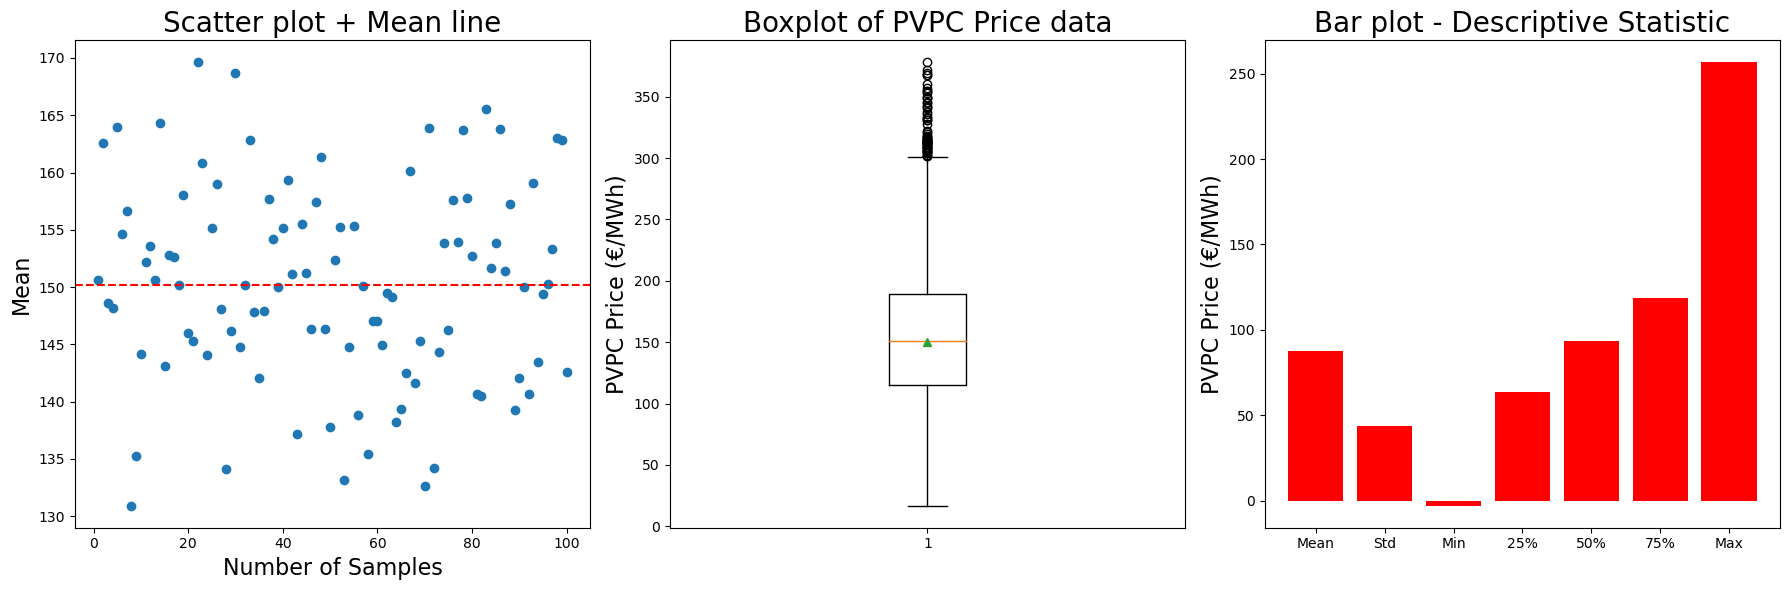

In [5]:
# DESCRIPTIVE STATISTIC 

print(PVPC_df.describe())

num_obs = 50
num_samples = 100
list_mean=[]
for sample in range(num_samples):
    s=PVPC_df['PVPC PRICE [€/MWh]'].sample(num_obs,random_state = sample)
    list_mean.append(s.mean())

price = [87.859718, 43.855175, -2.7, 63.5175, 93.275, 118.4925, 256.46]
labels = ['Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max']


# SUBPLOTS
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Mean for x samples of y observations
axs[0].scatter(range(1, 101), list_mean)
axs[0].axhline(np.mean(list_mean), color='red', linestyle='--')
axs[0].set_xlabel('Number of Samples', fontsize=16)
axs[0].set_ylabel('Mean', fontsize=16)
axs[0].set_title('Scatter plot + Mean line', fontsize=20)

# BOXPLOT
axs[1].boxplot(PVPC_df['PVPC PRICE [€/MWh]'], showmeans=True)
axs[1].set_ylabel('PVPC Price (€/MWh)', fontsize=16)
axs[1].set_title('Boxplot of PVPC Price data', fontsize=20)

# BAR PLOT
axs[2].bar(labels, price, color='red')
axs[2].set_title('Bar plot - Descriptive Statistic', fontsize=20)
axs[2].set_ylabel('PVPC Price (€/MWh)', fontsize=16)

# ADJUST
plt.tight_layout()

# Affichage des subplots
plt.show()

C:\Users\Leomu\AppData\Local\Temp\ipykernel_24344\3405660234.py:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




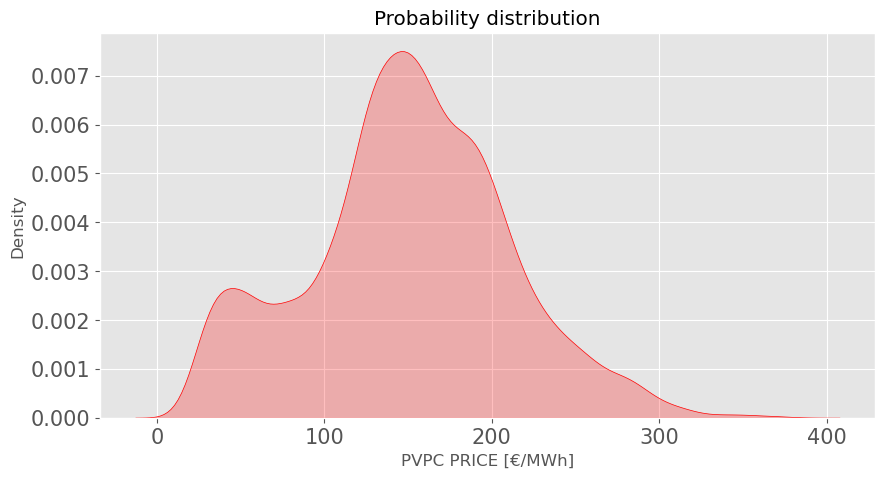

In [78]:
# plotting both distibutions on the same figure
plt.figure(figsize=(10,5))
plt.title('Probability distribution')
fig = sns.kdeplot(PVPC_df['PVPC PRICE [€/MWh]'], shade=True, color="r")
plt.savefig('stats4.png')
plt.show()

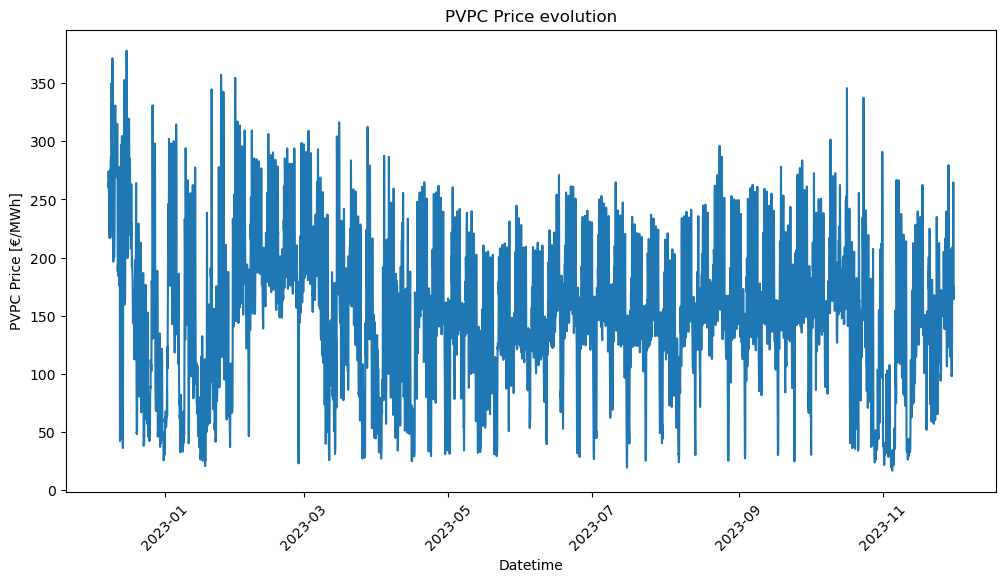

In [6]:
plt.figure(figsize=(12, 6))  # Largeur plus grande que la hauteur pour un graphique étroit

plt.plot(PVPC_df['PVPC PRICE [€/MWh]'],  )
plt.title('PVPC Price evolution')
plt.xlabel('Datetime')
plt.ylabel('PVPC Price [€/MWh]')
plt.xticks(rotation=45)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


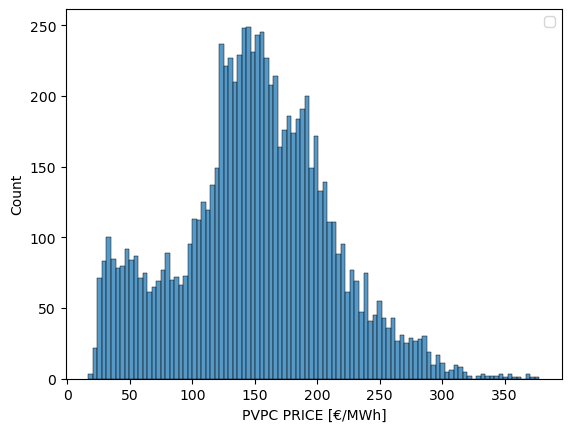

In [7]:
sns.histplot(data = PVPC_df['PVPC PRICE [€/MWh]'] ,bins=100)
plt.legend( loc='best', bbox_to_anchor=((1,1)))

In [8]:
import pandas as pd

# Supposons que votre DataFrame s'appelle PVPC1
# Remplacez 'Pourcentage_Renewables' et 'Prix_PVPC' par les noms réels de vos colonnes

# Conditions
condition = (PVPC_df['PVPC PRICE [€/MWh]'] < 10) & (PVPC_df['Ren(%)'] < 90)

# Suppression des lignes qui satisfont aux conditions
PVPC1_df = PVPC_df[~condition]

# PVPC1_filtered contient maintenant les lignes qui ne satisfont pas à ces conditions
PVPC1_df.describe()

,PVPC PRICE [€/MWh],RAD_SOL (W/m²),Ren(%),weekend,day_night,PVPC_-24h,PVPC_-7days,WindSpeed (km/h),Demand (MWh)
count,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000
mean,150.021253,152.383613,72.747725,0.284916,0.625000,150.597053,153.395101,18.873184,25618.948115
std,60.728377,237.191333,11.344249,0.451401,0.484151,61.819217,65.897212,10.828791,4113.047785
min,16.840000,0.000000,28.431822,0.000000,0.000000,16.840000,16.840000,0.400000,15800.700000
25%,114.785000,0.000000,64.667866,0.000000,0.000000,114.945000,115.672500,10.500000,22221.350000
50%,150.685000,1.000000,74.903160,0.000000,1.000000,150.815000,151.920000,17.800000,25808.350000
75%,189.295000,258.000000,81.799400,1.000000,1.000000,189.590000,191.622500,26.000000,28551.550000
max,377.890000,859.000000,92.705054,1.000000,1.000000,416.030000,450.640000,67.700000,36543.300000


In [9]:
import pandas as pd

# Supposons que votre DataFrame s'appelle PVPC_df
# Remplacez 'Pourcentage_Renewables' et 'Prix_PVPC' par les noms réels de vos colonnes

# Conditions
condition = (PVPC_df['PVPC PRICE [€/MWh]'] < 40) & (PVPC_df['Ren(%)'] < 70)

# Afficher une ligne qui satisfait aux conditions
ligne_satisfaisante = PVPC_df.loc[condition].head(1)
print("Ligne qui satisfait aux conditions :\n", ligne_satisfaisante)

# Suppression des lignes qui satisfont aux conditions
PVPC1_df = PVPC_df[~condition]

# Afficher le nombre de lignes avant et après la suppression
print("Nombre de lignes avant la suppression :", len(PVPC_df))
print("Nombre de lignes après la suppression :", len(PVPC1_df))

# PVPC1_filtered contient maintenant les lignes qui ne satisfont pas à ces conditions
PVPC1_df.describe()


Ligne qui satisfait aux conditions :
 Empty DataFrame
Columns: [PVPC PRICE [€/MWh], RAD_SOL (W/m²), Ren(%), weekend, day_night, PVPC_-24h, PVPC_-7days, WindSpeed (km/h), Demand (MWh)]
Index: []
Nombre de lignes avant la suppression : 8592
Nombre de lignes après la suppression : 8592


,PVPC PRICE [€/MWh],RAD_SOL (W/m²),Ren(%),weekend,day_night,PVPC_-24h,PVPC_-7days,WindSpeed (km/h),Demand (MWh)
count,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000
mean,150.021253,152.383613,72.747725,0.284916,0.625000,150.597053,153.395101,18.873184,25618.948115
std,60.728377,237.191333,11.344249,0.451401,0.484151,61.819217,65.897212,10.828791,4113.047785
min,16.840000,0.000000,28.431822,0.000000,0.000000,16.840000,16.840000,0.400000,15800.700000
25%,114.785000,0.000000,64.667866,0.000000,0.000000,114.945000,115.672500,10.500000,22221.350000
50%,150.685000,1.000000,74.903160,0.000000,1.000000,150.815000,151.920000,17.800000,25808.350000
75%,189.295000,258.000000,81.799400,1.000000,1.000000,189.590000,191.622500,26.000000,28551.550000
max,377.890000,859.000000,92.705054,1.000000,1.000000,416.030000,450.640000,67.700000,36543.300000


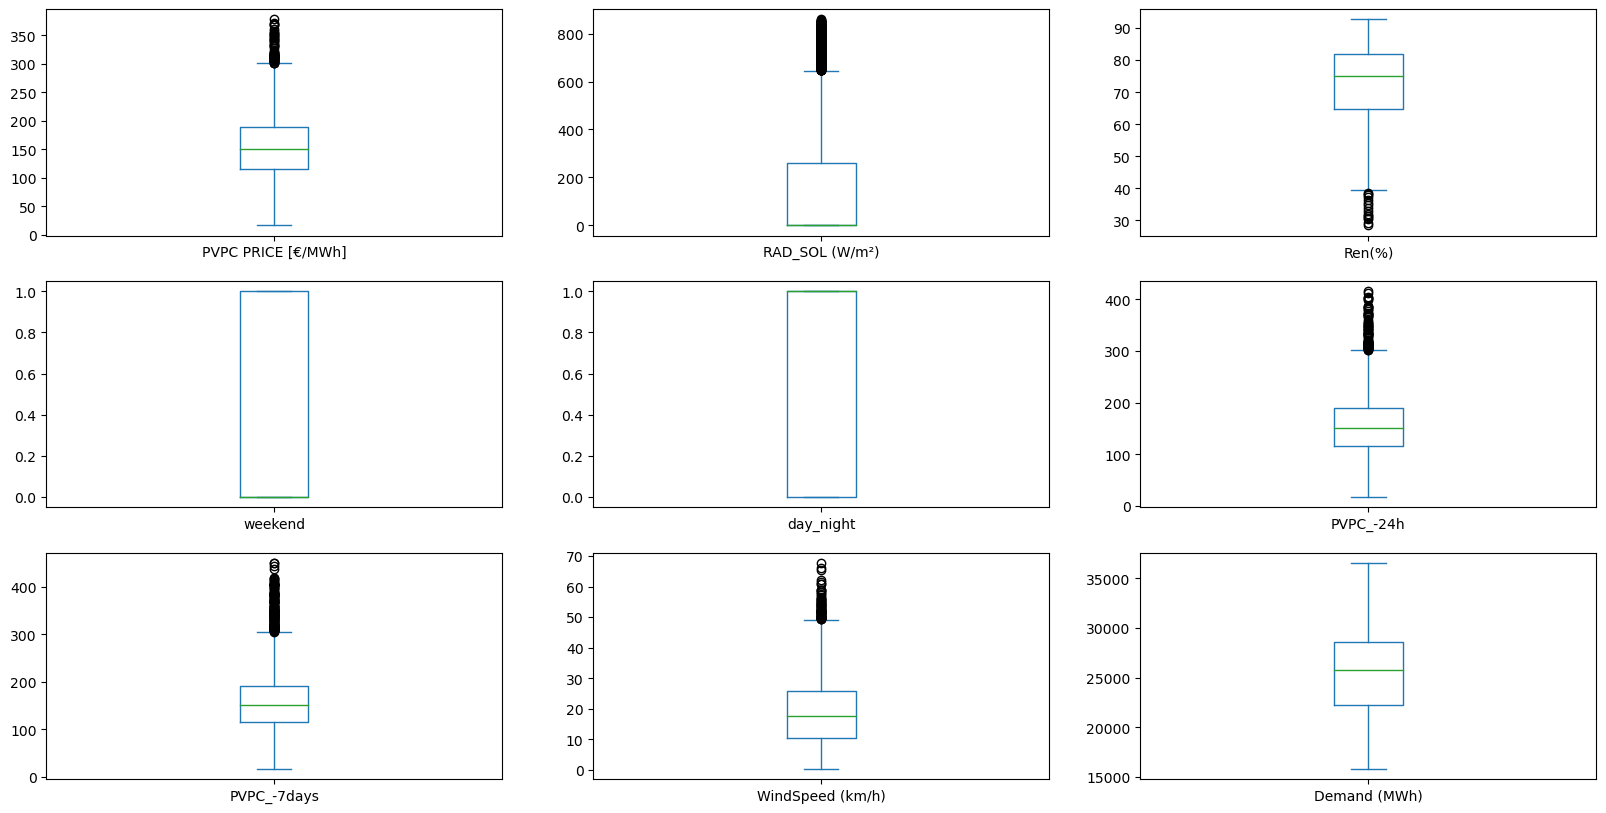

In [10]:
atributs_boxplot = PVPC1_df.plot(kind='box', subplots=True, layout=(3, 3), figsize=(20, 10), sharex=False,
                                 sharey=False, fontsize=10)
plt.savefig('boxplotall.png')
plt.show()

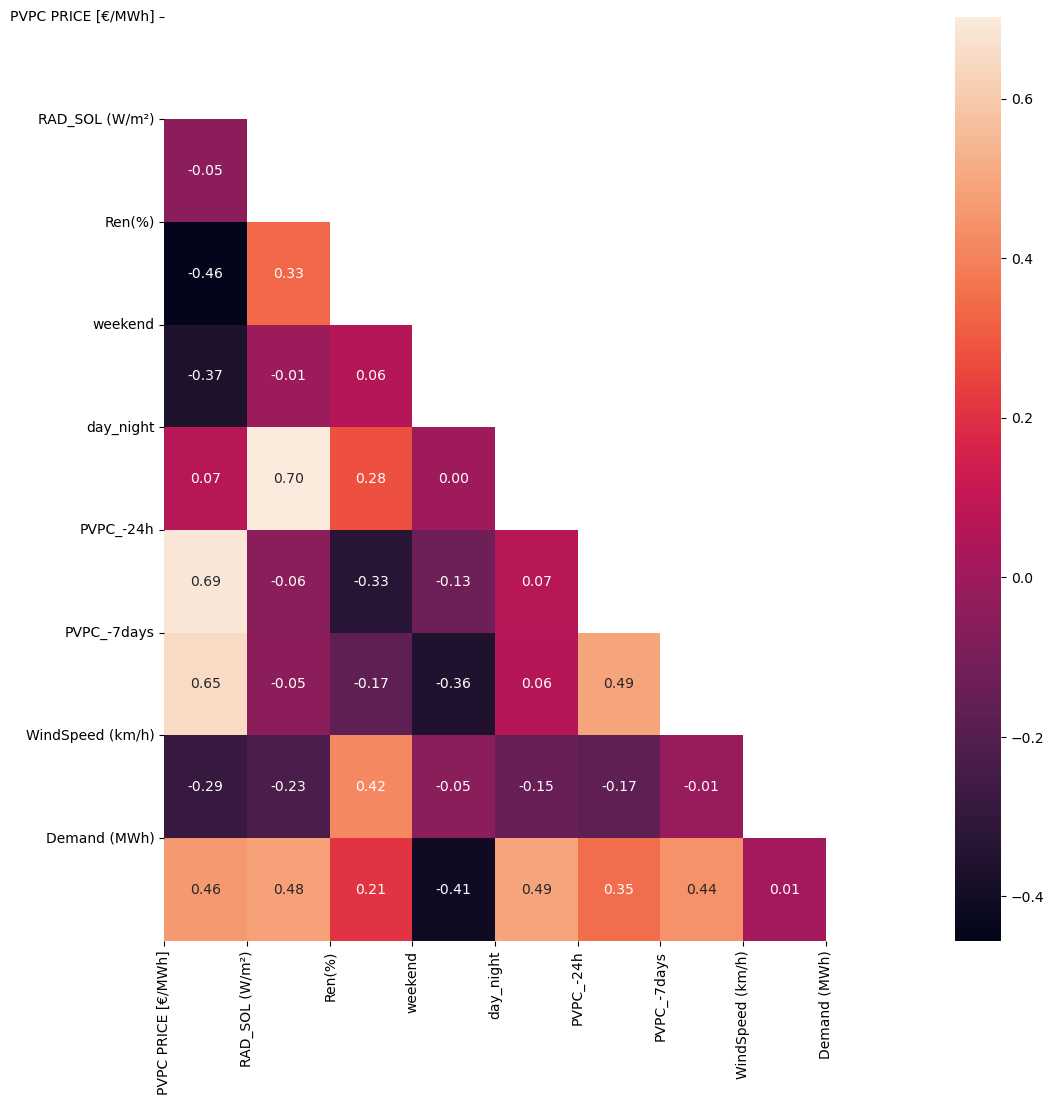

In [11]:
import seaborn as sns

# Calculation of correlation coefficients
corr_matrix = PVPC_df.corr(method='spearman')

# Remove repeated values
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 12))

#Generate Heat Map,
sns.heatmap(corr_matrix, annot=True, fmt=".2f" , mask=mask,)
    # xticks
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns);
    # yticks
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    # plot
plt.savefig('Corre.png')
plt.show()

In [50]:
# Separate between Atributes X (features); labels y (target) 
X = PVPC_df.drop(columns=['PVPC PRICE [€/MWh]'])  
y = PVPC_df['PVPC PRICE [€/MWh]'] 

print(f"Attributes (X) Shape: {X.shape}")
print(f"Target (y) Shape: {y.shape}")
print(' ')

# Get correlations 
price_correlations = corr_matrix['PVPC PRICE [€/MWh]']
print(price_correlations)

#We added %Renew energy -> WInd and %Renew are multicorrelated (not good for stability)
# Drop Wind
X=X.drop('WindSpeed (km/h)',axis=1)
print(f"WindSpeed (km/h): has been droped due to correlation with Ren(%)")
# Drop low correlatations attribute
threshold = 0.15  
attributes_to_drop = price_correlations[abs(price_correlations) < threshold].index.tolist()
print(f"{attributes_to_drop} : has been droped")                         
X = X.drop(attributes_to_drop, axis=1)



Attributes (X) Shape: (8592, 8)
Target (y) Shape: (8592,)
 
PVPC PRICE [€/MWh]    1.000000
RAD_SOL (W/m²)       -0.045207
Ren(%)               -0.455518
weekend              -0.367832
day_night             0.068526
PVPC_-24h             0.685622
PVPC_-7days           0.648500
WindSpeed (km/h)     -0.286398
Demand (MWh)          0.459993
Name: PVPC PRICE [€/MWh], dtype: float64
WindSpeed (km/h): has been droped due to correlation with Ren(%)
['RAD_SOL (W/m²)', 'day_night'] : has been droped


In [13]:
X.describe()


,Ren(%),weekend,PVPC_-24h,PVPC_-7days,Demand (MWh)
count,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000
mean,72.747725,0.284916,150.597053,153.395101,25618.948115
std,11.344249,0.451401,61.819217,65.897212,4113.047785
min,28.431822,0.000000,16.840000,16.840000,15800.700000
25%,64.667866,0.000000,114.945000,115.672500,22221.350000
50%,74.903160,0.000000,150.815000,151.920000,25808.350000
75%,81.799400,1.000000,189.590000,191.622500,28551.550000
max,92.705054,1.000000,416.030000,450.640000,36543.300000


In [14]:
print(X.dtypes, y.dtypes)

Ren(%)          float64
weekend           int32
PVPC_-24h       float64
PVPC_-7days     float64
Demand (MWh)    float64
dtype: object float64


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# NORMALIZATION

# TARGET
scaler_y = MinMaxScaler()
ydf = y.copy()
ydf = pd.DataFrame(ydf)
y_scaled = scaler_y.fit_transform(ydf)
y_scaled = np.ravel(y_scaled)


# Attributs

scaler = MinMaxScaler()
Xdf_scaled = X.copy()
X_scaled = pd.DataFrame(scaler.fit_transform(Xdf_scaled))
X_scaled.columns = Xdf_scaled.columns
X_scaled

,Ren(%),weekend,PVPC_-24h,PVPC_-7days,Demand (MWh)
0,0.459109,0.0,0.892031,0.640917,0.345839
1,0.499814,0.0,0.926802,0.605763,0.283311
2,0.513057,0.0,0.968135,0.627939,0.244593
3,0.523883,0.0,0.991157,0.633933,0.215494
4,0.529698,0.0,1.000000,0.594514,0.202419
...,...,...,...,...,...
8587,0.741947,0.0,0.465868,0.502905,0.709308
8588,0.743930,0.0,0.476841,0.446842,0.718521
8589,0.716733,0.0,0.471129,0.403227,0.683468
8590,0.695831,0.0,0.347504,0.267635,0.560846


In [16]:
# Train and Test data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
test_size = 0.2  # percentage of the input data that you will use to validate the model

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size,
                                                    shuffle=False)

In [51]:
print("Taille de l'ensemble d'entraînement :", len(X_train))
print("Taille de l'ensemble de validation   :", len(X_val))
print("Taille de l'ensemble de test         :", len(X_test))

Taille de l'ensemble d'entraînement : 5498
Taille de l'ensemble de validation   : 1375
Taille de l'ensemble de test         : 1719


In [52]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

num_folds = 5
error_metrics = {'neg_mean_absolute_error'} #'neg_root_mean_squared_error', 
models = {('MLP', MLPRegressor()),('RFR', RandomForestRegressor())} #,('SVR', SVR()), ('AdaB', AdaBoostRegressor())}

Evaluation metric:  neg_root_mean_squared_error
Model  SVR
Model  MLP
Model  AdaB
Model  RFR
[('SVR', -0.07618098013046329, 0.0021496914056728794), ('MLP', -0.08791625020393286, 0.0025403510941332903), ('AdaB', -0.08802471508429914, 0.0012566966183483806), ('RFR', -0.06653094420459797, 0.0015740994761556724)]


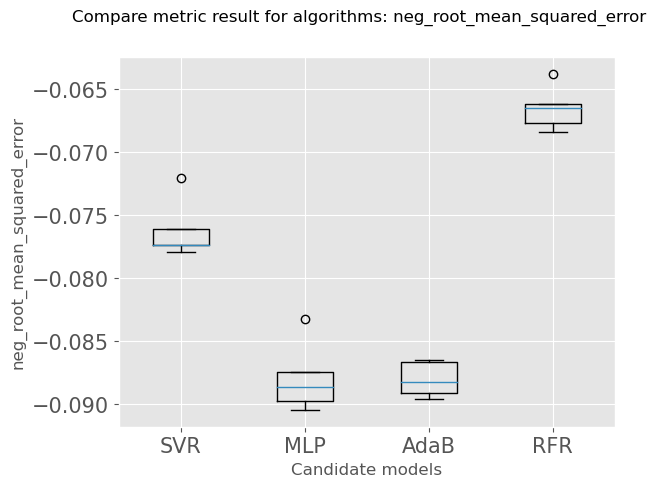

Evaluation metric:  neg_mean_absolute_error
Model  SVR
Model  MLP
Model  AdaB
Model  RFR
[('SVR', -0.05845003942068618, 0.0013357903608904606), ('MLP', -0.0658690845876258, 0.001965633100560504), ('AdaB', -0.0680878188050865, 0.001705158279174183), ('RFR', -0.047617228402252146, 0.0008305898266601979)]


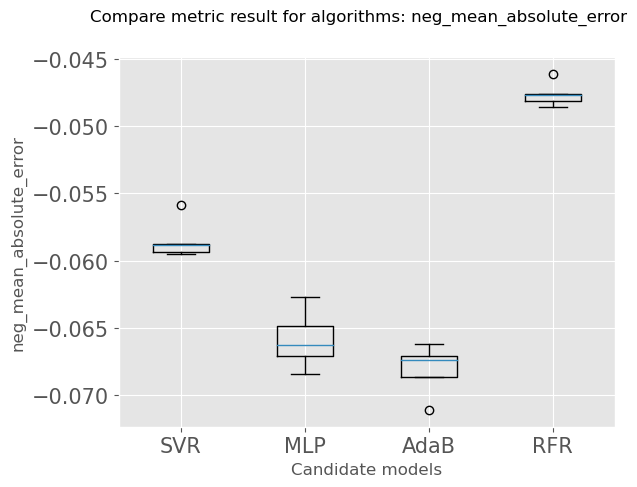

In [53]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# Cross-validation training
for scoring in error_metrics:
    results = [] # store metrics results
    msg = []  # print summary of result
    names = []  # store name of the models
    print('Evaluation metric: ', scoring)
    for name, model in models:
        print('Model ', name)
        cross_validation = KFold(n_splits=num_folds, shuffle=False)
        cv_results = cross_val_score(model, X_train, y_train, cv=cross_validation, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        resume = (name, cv_results.mean(), cv_results.std())
        msg.append(resume)
    print(msg)

    # Compare results between algorithms
    fig = plt.figure()
    fig.suptitle('Compare metric result for algorithms: %s' %scoring)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Candidate models')
    ax.set_ylabel('%s' %scoring)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.savefig('RMSEComparison')
    plt.show()

    results = []


In [19]:
# RFR seems to be the best regression model : 

modelo = RandomForestRegressor()
scoring='neg_root_mean_squared_error'
params = {
    # Number of trees in random forest
    'n_estimators': [5, 100, 300],  # default=100
     # Maximum number of levels in tree
    'max_depth': [None, 5,10],  #deafult = None
     # Method of selecting samples for training each tree
    'min_samples_split': [2, 5, 10],
}


# Search for the best combination of hyperparameters
cross_validation = KFold(n_splits=5, shuffle=False)
my_cv = cross_validation.split(X_val)
gsearch = GridSearchCV(estimator=modelo, param_grid=params, scoring=scoring, cv=my_cv)
gsearch.fit(X_val, y_val)

# Print best Result
print("Best result: %f using the following hyperparameters %s" % (gsearch.best_score_, gsearch.best_params_))
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
params = gsearch.cv_results_['params']

Best result: -0.075019 using the following hyperparameters {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In [67]:
final_model = RandomForestRegressor() ## train again with the winner model from the Grid Search
final_model.fit(X_train,y_train)  # Model training 
y_predict = final_model.predict(X_test)  # prediction calculation
y_predict

array([0.29917934, 0.40810082, 0.53403933, ..., 0.32318903, 0.33909542,
       0.61748677])

In [68]:
import math 
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Invert the scaling and plot the results
y_test_unsc = np.reshape(y_test, (len(y_test), 1))
y_test_inv = scaler_y.inverse_transform(y_test_unsc)

y_predict_uns = np.reshape(y_predict, (len(y_predict), 1))
y_predict_inv = scaler_y.inverse_transform(y_predict_uns)
y_test_inv

array([[164.  ],
       [166.85],
       [244.74],
       ...,
       [119.86],
       [135.21],
       [227.04]])

In [69]:
# Error RMSE de test  
math.sqrt(mean_squared_error(y_test,y_predict))

0.06618307376990393

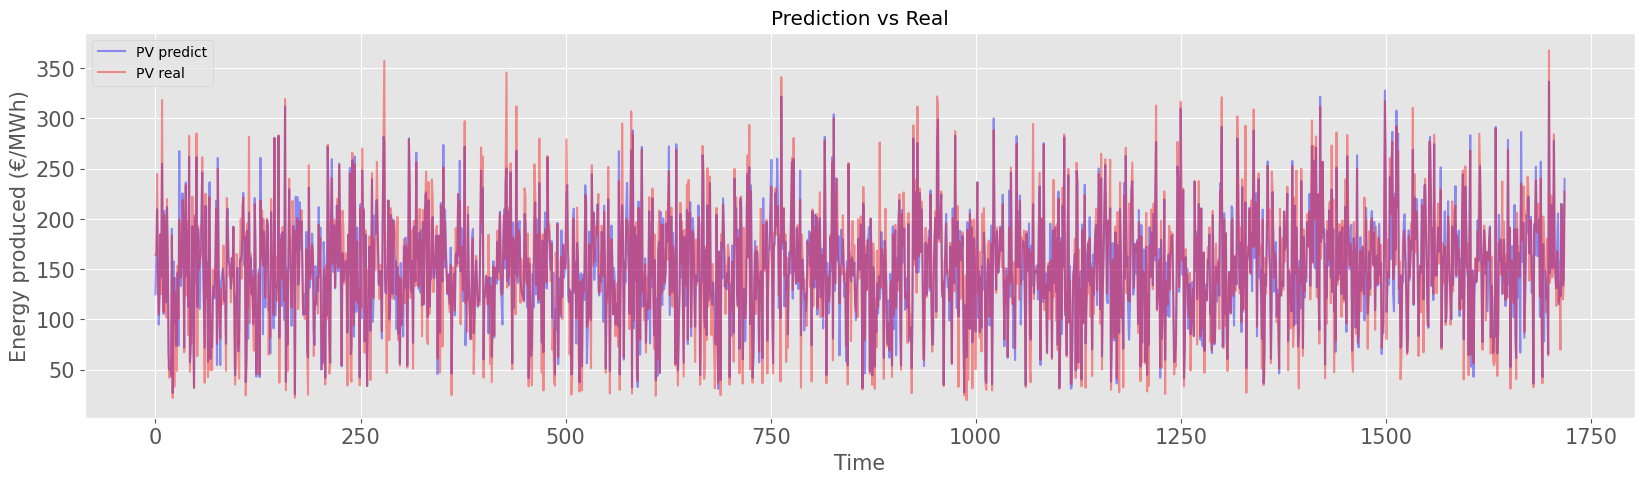

In [84]:
# Plot the prediction on the test datas vs the real data y
x = range(len(y_predict_inv))
plt.figure(figsize=(20,5))
plt.xlabel('Time', size=15)
plt.ylabel('Energy produced (€/MWh)', size=15)
plt.plot(x, y_predict_inv, alpha=0.4, color='blue', label='PV predict')
plt.plot(x, y_test_inv, alpha=0.4, color='red',  label='PV real')
plt.title('Prediction vs Real')
plt.legend()
plt.savefig('PredVSReal1.png')
plt.show()


In [83]:
# Plot the same with better color

import plotly.graph_objects as go 

init = list(range(len(y_predict_inv)))
y_predict_plot = pd.DataFrame(data=y_predict_inv, index=init, columns=['predict'])
y_test_plot = pd.DataFrame(data=y_test_inv, index=init, columns=['test'])


# We create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=init, y=y_predict_plot['predict'][init],
                    mode='lines',
                    name='PV prediction'))
fig.add_trace(go.Scatter(x=init, y=y_test_plot['test'][init],
                     mode='lines', name='PV real'))


# We edit figure
fig.update_layout(autosize=False,
                  width=1000,
                    height=500,
                    title='Prediction vs Real',
                   xaxis_title='Periods',
                   yaxis_title='Energy (€/MWh)')


fig.show()

DatetimeIndex(['2022-12-08 00:00:00', '2022-12-08 01:00:00',
               '2022-12-08 02:00:00', '2022-12-08 03:00:00',
               '2022-12-08 04:00:00', '2022-12-08 05:00:00',
               '2022-12-08 06:00:00', '2022-12-08 07:00:00',
               '2022-12-08 08:00:00', '2022-12-08 09:00:00',
               ...
               '2023-11-30 14:00:00', '2023-11-30 15:00:00',
               '2023-11-30 16:00:00', '2023-11-30 17:00:00',
               '2023-11-30 18:00:00', '2023-11-30 19:00:00',
               '2023-11-30 20:00:00', '2023-11-30 21:00:00',
               '2023-11-30 22:00:00', '2023-11-30 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=8592, freq=None)

In [33]:
# PREDICTION OF THE 1st OF DECEMBER

# Create the dataset with tomorrow's forecast
Tom_df=pd.DataFrame()

#ADD %RENEWABLE ENERGY FOR 1st OF DECEMBER
Ren_df=pd.read_csv('RT2.csv')
Tom_df['Ren']=Ren_df['value']

#ADD DEMAND IN ENERGY FOR 1st OF DECEMBER
Dem_df=pd.read_csv('F_Demand.csv')
Tom_df['Demand']=Dem_df['F_Demand']

#ADD PRICE PVPC-24h and -7d FOR 1st OF DECEMBER
PrevPVPC_df=pd.read_excel('Previous_PVPC.xlsx')
PrevPVPC_df
Tom_df['PVPC24h']=PrevPVPC_df['PVPC24h']
Tom_df['PVPC7j']=PrevPVPC_df['PVPC7j']

#ADD IF 1st OF DECEMBER IS A WEEKDAY OR WEEK-END DAY
Tom_df['weekend']=0
Tom_df

#Reorder the dataset the same as PVPC_df because we use the same standardization of data
new_order=['Ren','weekend','PVPC24h','PVPC7j','Demand']
Tom_df = Tom_df[new_order]

Tom_df


,Ren,weekend,PVPC24h,PVPC7j,Demand
0,77.700506,0,109.69,72.64,23907.7
1,79.310535,0,102.51,69.22,22591.6
2,79.842707,0,98.12,65.47,21625.7
3,79.929812,0,98.97,65.98,21273.1
4,79.715981,0,98.59,65.77,21115.2
5,77.893437,0,98.97,71.17,21836.0
6,74.489564,0,109.78,108.72,24378.1
7,73.466407,0,138.12,131.53,27854.5
8,71.911609,0,160.68,162.53,29090.9
9,75.843989,0,160.62,129.46,29511.0


In [34]:
#STANDARDIZATION (CAREFULL IT HAS TO BE WITH THE HOLE DATA OTHERWISE IT WILL ONLY STANDARDIZE ON THE 24 DATAS)

Tomdf_scaled = Tom_df.copy()
Tomdf_scaled.columns = Xdf_scaled.columns
Tom_scaled = pd.DataFrame(scaler.transform(Tomdf_scaled))
Tom_scaled.columns=  Xdf_scaled.columns
Tom_scaled

,Ren(%),weekend,PVPC_-24h,PVPC_-7days,Demand (MWh)
0,0.766551,0.0,0.232596,0.128631,0.390838
1,0.791600,0.0,0.214610,0.120747,0.327389
2,0.799880,0.0,0.203612,0.112102,0.280823
3,0.801235,0.0,0.205742,0.113278,0.263824
4,0.797909,0.0,0.204790,0.112794,0.256212
5,0.769552,0.0,0.205742,0.125242,0.290962
6,0.716593,0.0,0.232821,0.211803,0.413516
7,0.700674,0.0,0.303815,0.264385,0.581113
8,0.676484,0.0,0.360330,0.335846,0.640720
9,0.737666,0.0,0.360179,0.259613,0.660973


In [35]:
#FINAL PREDICTION

y_predict_final_scaled =  final_model.predict(Tom_scaled)

y_predict_final= scaler_y.inverse_transform(y_predict_final_scaled.reshape(-1, 1))
y_predict_final



array([[128.1548],
       [143.6726],
       [133.4594],
       [128.9839],
       [138.4042],
       [139.1595],
       [129.6929],
       [136.0203],
       [160.6712],
       [159.9033],
       [206.9172],
       [207.4637],
       [191.503 ],
       [179.901 ],
       [145.8173],
       [147.4262],
       [158.5661],
       [179.3974],
       [217.0663],
       [219.8257],
       [204.3723],
       [185.5054],
       [155.9037],
       [147.3605]])

2023-12-01T00:00 2023-12-01T23:59
Connection is established
200


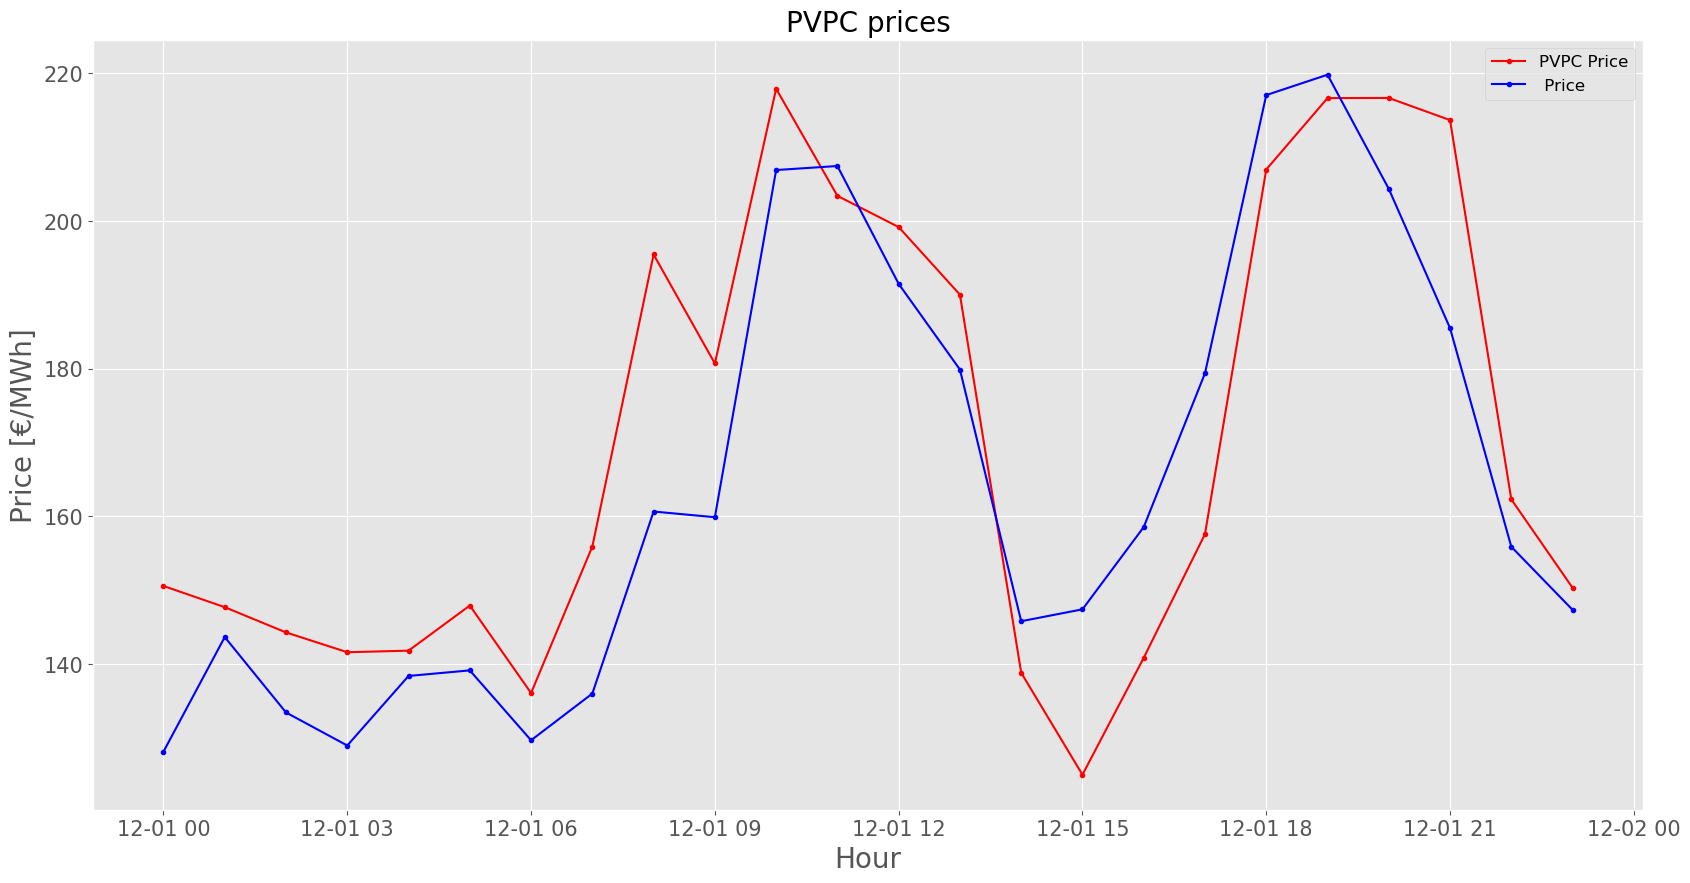

In [38]:
# PLOT OUR FINAL PREDICTION WITH THE REAL DATA TO BE ABLE TO COMPARE 

endpoint = 'https://apidatos.ree.es'

get_archives = '/es/datos/mercados/precios-mercados-tiempo-real'
#get_archives = '/es/datos/mercados/componentes-precio'

headers = {'Accept': 'application/json',
           'Content-Type': 'application/json',
           'Host': 'apidatos.ree.es'}

# Most updated values

#start_date = datetime.now() - timedelta(hours=24)
#end_date = start_date + timedelta(hours=24) # add one day to see prices for tomorrow
start_date ='2023-12-01T00:00'
end_date = '2023-12-01T23:59'
# transform into strings with a minute resolution
#end_date = end_date.strftime('%Y-%m-%dT%H:%M')
#start_date = start_date.strftime('%Y-%m-%dT%H:%M')


params = {'start_date': start_date, 'end_date': end_date, 'time_trunc':'hour'}
print(start_date, end_date)

#################################################################################################################################

#STATUS 
response = requests.get(endpoint+get_archives, headers=headers, params=params)
status = response.status_code

#Check the status code
if status < 200:
    print('informational')
    # If the status code is 200, treat the information.
elif status >= 200 and status < 300:
    print('Connection is established')
    #okBehavior(response) # runs the function to get list of archives
elif status >= 300 and status < 400:
    print('redirection')
elif status >= 400 and status < 500:
    print('client error')
else:
    print('server error')

print(response.status_code)

#################################################################################################################################

# accessing data by means of a json object
data_json = response.json()

#################################################################################################################################

# Looking in json for the data we want 
pvpc_data = data_json['included'][0]
pvpc_values = pvpc_data['attributes']['values']

# NEw list
pvpc_prices = []
times = []

for data_point in pvpc_values:
    #print(time_period['value'])
    pvpc_prices.append(data_point['value'])
    times.append(data_point['datetime'])
    #print(f"PVPC price at {data_point['datetime']} is {data_point['value']} €/MWh")
    
# Convert each string to datetime object
times = [datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S.%f%z") for date_str in times]

#################################################################################################################################

Df = pd.DataFrame({'Datetime': times, 'PVPC [€]': pvpc_prices })
Df.head()

#################################################################################################################################

#Plot 
matplotlib.rc('xtick', labelsize=15)     
matplotlib.rc('ytick', labelsize=15)

plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(times, pvpc_prices, 'r', linewidth=1.5, marker='.', label='PVPC Price')
plt.plot(times, y_predict_final, 'b', linewidth=1.5, marker='.', label=' Price')
plt.title(f"PVPC prices", fontsize=20)
plt.xlabel('Hour', fontsize=20 )
plt.ylabel('Price [€/MWh]', fontsize=20)
plt.legend(fontsize='large')
plt.savefig('PVPC-Price.png')
plt.show()
